In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from kepler import kepler

/Users/sjm/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
kicid = 9651065

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

times = times[2500:]
dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)

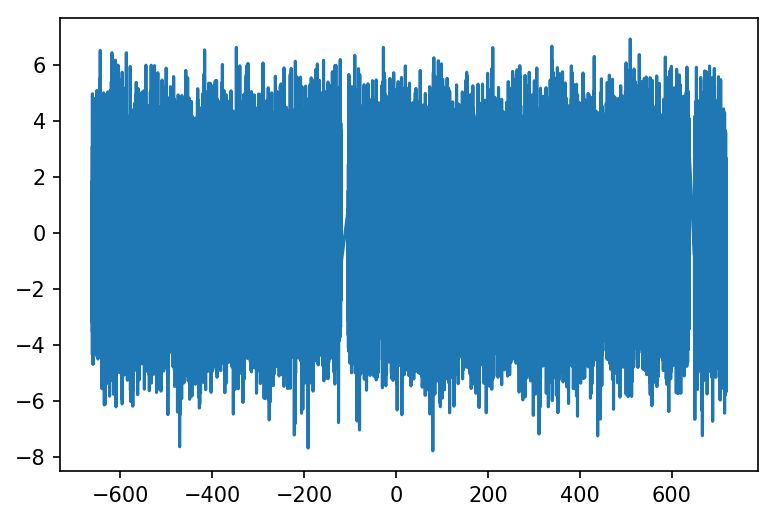

In [4]:
plt.plot(times,dmmags)

In [5]:
nu_arr = metadata[::6]
nu_arr

array([ 19.47767438,  21.71213375,  30.80189732,  17.69941551,
        22.69429318,  24.45638328,  16.26846361,  13.62339726,  36.14642035])

In [6]:
orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

In [7]:
orbits.columns

Index(['Name', 'Porb', 'Porb_sig_p', 'Porb_sig_m', 'a1sini/c',
       'a1sini/c_sig_p', 'a1sini/c_sig_m', 'e', 'e_sig_p', 'e_sig_m', 'phip',
       'phip_sig_p', 'phip_sig_m', 'varpi', 'varpi_sig_p', 'varpi_sig_m',
       'f(M)Msun', 'f(M)Msun_sig_p', 'f(M)Msun_sig_m', 'gradient',
       'grad_sig_p', 'grad_sig_m', 't_p', 't_p_sig_p', 't_p_sig_m', 'K1_ms',
       'K1_ms_sig_p', 'K1_ms_sig_m', 'median_segment_size'],
      dtype='object')

In [8]:
orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0
e_param = np.log(e) - np.log(1.0 - e)

In [9]:
e

0.46671099999999999

Here's where the TensorFlow stuff starts. The "session" is the thing that will actually do that calculations.

In [10]:
sess = tf.InteractiveSession()

The way that TensorFlow works is that you define the operations on `Variable` and `placeholder` objects. Here we describe the model: 

In [11]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
a1d_tensor = tf.Variable(a1d, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

In [12]:
# Here we define how the time delay will be calculated:
tau_tensor = -a1d_tensor * (1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

Here's how you could evaluate different parts of the model:

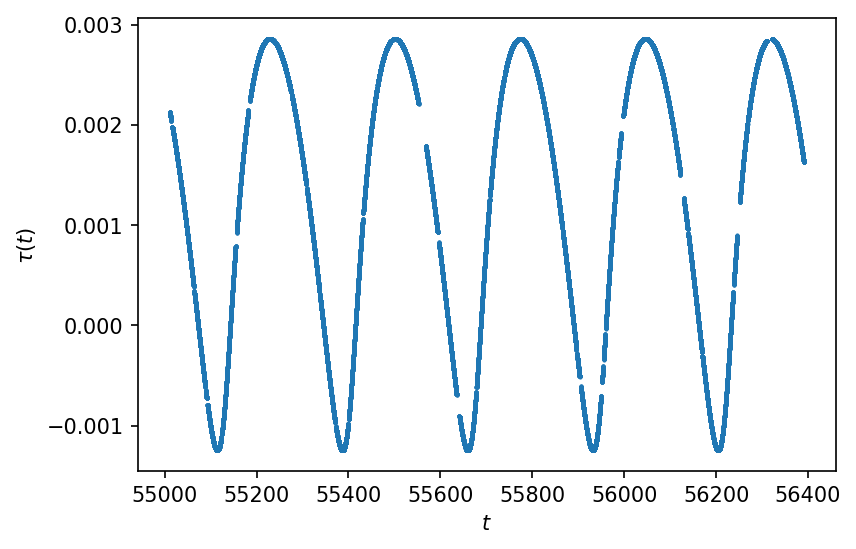

In [13]:
# We need to initialize the variables:
tf.global_variables_initializer().run()

# We'll also need to pass in the data:
data = {times_tensor: times, dmmags_tensor: dmmags}

# Let's plot the initial time delay
initial_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

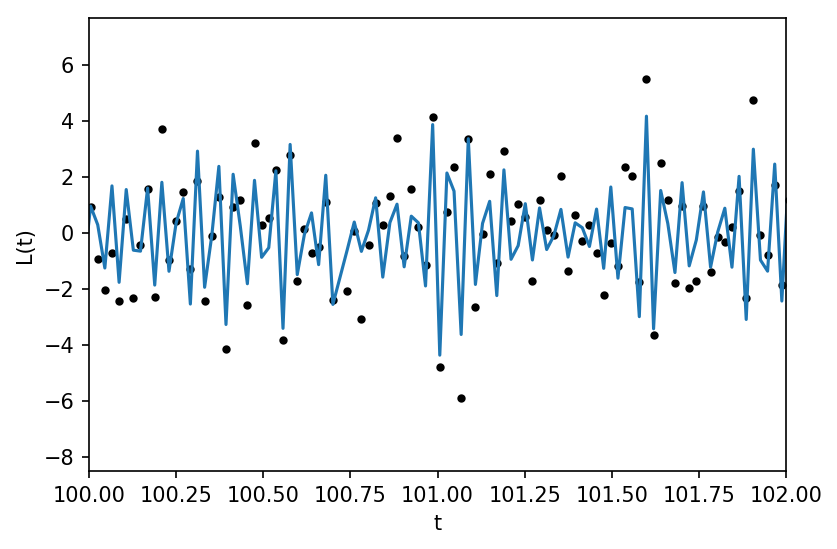

In [14]:
initial_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
plt.xlim(100, 102)
# plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");

Now we'll fit the parameters. We'll iterate with different subsets a few times.

In [15]:
for i in range(5):
    params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(a1d_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [e_param_tensor, varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68068.225002
  Number of iterations: 25
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68067.741115
  Number of iterations: 2
  Number of functions evaluations: 15
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68067.741112
  Number of iterations: 1
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68067.741110
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68067.741107


Let's make the updated final plots.

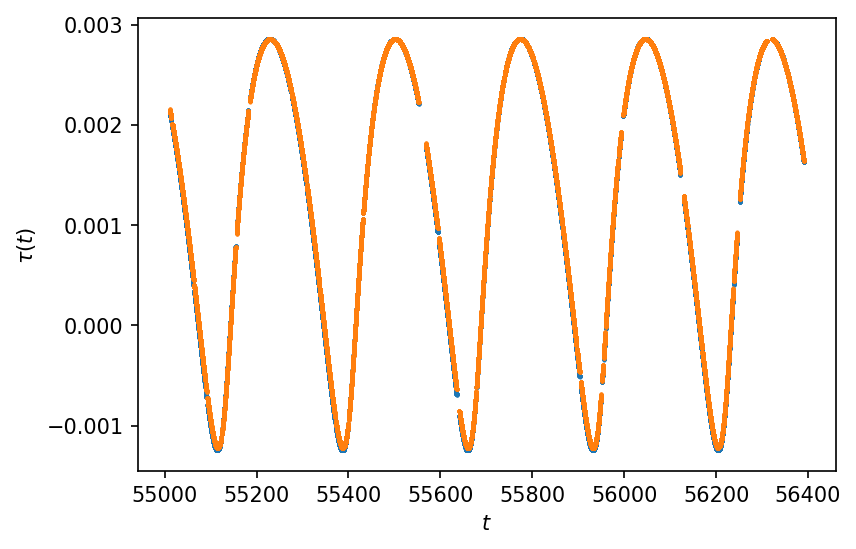

In [16]:
final_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.plot(times+tmid, final_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

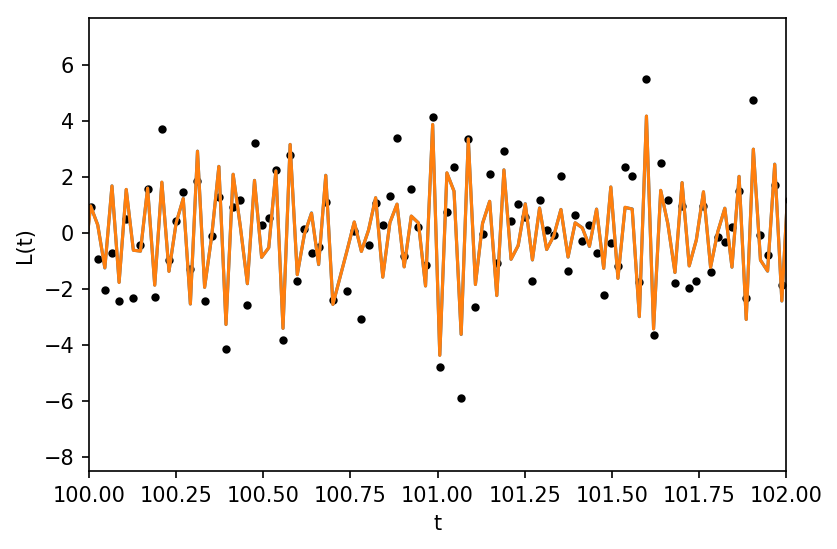

In [17]:
final_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
plt.plot(times, final_model)
plt.xlim(100, 102)
# plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");

In [18]:
sess.run([log_sigma2_tensor, e_tensor, varpi_tensor, porb_tensor]), porb

([0.10630100264471491,
  0.47652334257582457,
  2.199820708056782,
  272.26079138991884],
 272.42512799999997)

In [19]:
def log_prob(theta, session, data, log_prob_fn, params):
    i = 0
    for p in params:
        l = p.shape
        if len(l):
            l = int(l[0])
            p.assign(params[i:i+l])
            i += l
        else:
            p.assign(params[i])
            i += 1
    return session.run(log_prob_fn, feed_dict=data)

In [20]:
log_prob_fn = -e_param_tensor - 2.0 * tf.log(1.0 + tf.exp(-e_param_tensor)) # -0.5 * chi2_tensor
# params = [log_sigma2_tensor, porb_tensor, tp_tensor, a1d_tensor, e_param_tensor, varpi_tensor, nu_tensor[0]]
params = [e_param_tensor]

theta = np.concatenate(list(map(np.atleast_1d, sess.run(params))))
log_prob(theta, sess, data, log_prob_fn, params)

-1.3885014086337151

In [21]:
import emcee

nwalkers = 32
ndim = len(initial)
p0 = initial + 1e-8*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(sess, data, log_prob_fn, params))
sampler.run_mcmc(p0, 100, progress=True);

ModuleNotFoundError: No module named 'emcee'

In [ ]:
chain = sampler.get_chain();

In [ ]:
plt.plot(1.0 / (1 + np.exp(-chain[:, :, 0])));

In [ ]:
e0 = np.random.uniform(0, 1, 50000)
e0_param = np.log(e0) - np.log(1.0 - e0)
plt.hist(e0_param, 100, normed=True)
xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.exp(-xx)/(1+np.exp(-xx))**2);